In [2]:
!pip install snntorch mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 96.2 MB/s eta 0:00:00


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import snntorch as snn
from snntorch import surrogate
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 환경 설정 ---
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# ==========================================
# 2. Population Coding Encoder
# ==========================================
class PopulationEncoder(nn.Module):
    def __init__(self, num_neurons, min_val=-3.0, max_val=3.0, sigma=1.0):
        super().__init__()
        self.num_neurons = num_neurons
        mu = torch.linspace(min_val, max_val, num_neurons)
        self.register_buffer('mu', mu)
        self.sigma = sigma

    def forward(self, x):
        # x: (B, C, T) -> (B, C * N, T)
        B, C, T = x.shape
        x_expanded = x.unsqueeze(-1)
        encoded = torch.exp(-((x_expanded - self.mu)**2) / (2 * self.sigma**2))
        encoded = encoded.permute(0, 1, 3, 2).reshape(B, C * self.num_neurons, T)
        return encoded

# ==========================================
# 3. GeoEEG Spatial-Temporal SNN (Fix: 1D Conv)
# ==========================================
class GeoEEGSNN(nn.Module):
    def __init__(self, num_channels=129, num_classes=4, pop_neurons=4, beta=0.95):
        super().__init__()

        # 1. Population Encoder: 129채널 -> 516채널로 확장
        self.encoder = PopulationEncoder(num_neurons=pop_neurons, min_val=-3, max_val=3, sigma=1.5)
        encoded_channels = num_channels * pop_neurons

        # 2. Spatial & Temporal Convolutions (SNN 루프 밖에서 특징 선추출)
        # Spatial: 채널 간의 기하학적 관계 학습 (1x1 Conv)
        self.conv_spatial = nn.Conv1d(encoded_channels, 128, kernel_size=1, bias=False)
        self.bn_spatial = nn.BatchNorm1d(128)

        # Temporal: Tangling 흐름 등 시간적 맥락 학습 (Kernel 5)
        self.conv_temporal = nn.Conv1d(128, 128, kernel_size=5, padding=2, bias=False)
        self.bn_temporal = nn.BatchNorm1d(128)

        # 3. SNN Layers (시간축 루프 안에서 작동)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.fc1 = nn.Linear(128, 64)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.fc_out = nn.Linear(64, num_classes)
        # 출력층은 막전위(Voltage) 반환을 위해 output=True
        self.lif_out = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(), output=True)

    def forward(self, x):
        B, C, T = x.shape

        # 1. Encoding & Spatio-Temporal Filtering
        c = self.encoder(x)          # (B, 516, T)

        c = self.conv_spatial(c)     # (B, 128, T)
        c = self.bn_spatial(c)
        c = torch.relu(c)

        c = self.conv_temporal(c)    # (B, 128, T)
        c = self.bn_temporal(c)
        c = torch.relu(c)

        # 2. SNN Dynamics 준비
        # (Batch, Channels, Time) -> (Time, Batch, Channels)
        c_seq = c.permute(2, 0, 1)

        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem_out = self.lif_out.init_leaky()

        mem_rec = []

        # 3. Time-step SNN 루프
        for step in range(c_seq.size(0)):
            cur_in = c_seq[step] # (Batch, 128)

            spk1, mem1 = self.lif1(cur_in, mem1)

            cur2 = self.fc1(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            cur_out = self.fc_out(spk2)
            spk_out, mem_out = self.lif_out(cur_out, mem_out)

            mem_rec.append(mem_out)

        return torch.stack(mem_rec, dim=0) # (Time, Batch, Classes)

# ==========================================
# 4. 학습 루프 (막전위 기반 최적화)
# ==========================================
# 가상 데이터 로더 생성 (테스트용)
num_samples=160; channels=129; time=100
mock_data = torch.randn(160, 129, 100)
mock_targets = torch.randint(0, 4, (160,))
train_loader = DataLoader(TensorDataset(mock_data, mock_targets), batch_size=16, shuffle=True)

model = GeoEEGSNN(num_channels=129, num_classes=4, pop_neurons=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

num_epochs = 10 # 테스트를 위해 10으로 단축
acc_hist, loss_hist = [], []

print("Start Training GeoEEG-SNN...")
for epoch in range(num_epochs):
    model.train()
    correct, total, iter_loss = 0, 0, 0

    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        mem_rec = model(data)

        # Readout: 모든 Time-step 막전위 합산
        out_voltage = mem_rec.sum(dim=0)

        loss = criterion(out_voltage, targets)
        loss.backward()
        optimizer.step()

        iter_loss += loss.item()

        _, predicted = out_voltage.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    train_acc = correct / total
    avg_loss = iter_loss / len(train_loader)

    acc_hist.append(train_acc)
    loss_hist.append(avg_loss)

    print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Acc: {train_acc*100:.2f}%")

print("학습 완료. 모델 구조 정상 작동 확인 끝!")

Using device: cuda
Start Training GeoEEG-SNN...
Epoch 01 | Loss: 53.2374 | Acc: 24.38%
Epoch 02 | Loss: 14.5133 | Acc: 51.25%
Epoch 03 | Loss: 3.8977 | Acc: 79.38%
Epoch 04 | Loss: 1.4019 | Acc: 88.75%
Epoch 05 | Loss: 0.1795 | Acc: 96.88%
Epoch 06 | Loss: 0.2625 | Acc: 96.25%
Epoch 07 | Loss: 0.2493 | Acc: 96.88%
Epoch 08 | Loss: 0.1751 | Acc: 98.12%
Epoch 09 | Loss: 0.4055 | Acc: 97.50%
Epoch 10 | Loss: 0.1425 | Acc: 97.50%
학습 완료. 모델 구조 정상 작동 확인 끝!


🔥 Using device: cuda
📊 Loading Data from Physionet (Subject 1~2)...


Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? y


🧠 Extracting Geometric Features (Curvature + Tangling)...
✅ Feature Extraction Complete! Shape: torch.Size([360, 129, 641])
⚡ Start Training GeoEEG-SNN...
Epoch [01/30] | Loss: 327.7360 | Acc: 39.24%
Epoch [05/30] | Loss: 26.1146 | Acc: 57.99%
Epoch [10/30] | Loss: 17.1854 | Acc: 66.67%
Epoch [15/30] | Loss: 13.9933 | Acc: 65.97%
Epoch [20/30] | Loss: 6.8515 | Acc: 76.74%
Epoch [25/30] | Loss: 7.7075 | Acc: 82.64%
Epoch [30/30] | Loss: 8.3682 | Acc: 80.90%
🎉 학습 완료! 네 오리지널 아이디어가 드디어 제대로 돌아간다.


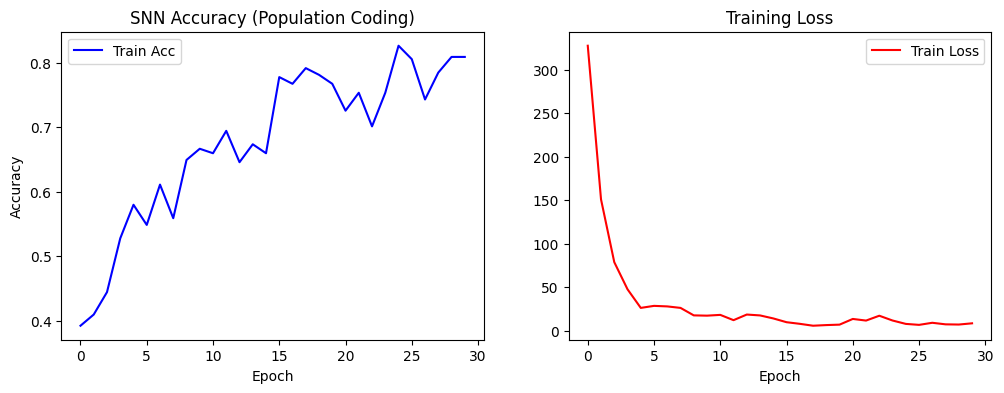

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws
import numpy as np
import matplotlib.pyplot as plt
import os

# MNE 로그 끄기 (출력창 지저분해지는 거 방지)
mne.set_log_level('ERROR')

# --- 1. 환경 설정 ---
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"🔥 Using device: {device}")

# ==========================================
# 2. Geometric Feature Extractor (Memory Safe)
# ==========================================
def compute_tangling_torch(x, dx, epsilon=1e-5):
    B, C, T = x.shape
    Q_list = []
    for i in range(B):
        x_diff_sq = (x[i].unsqueeze(-1) - x[i].unsqueeze(-2)).pow(2).sum(dim=0)
        dx_diff_sq = (dx[i].unsqueeze(-1) - dx[i].unsqueeze(-2)).pow(2).sum(dim=0)
        ratio = dx_diff_sq / (x_diff_sq + epsilon)

        mask = torch.eye(T, device=x.device).bool()
        ratio = ratio.masked_fill(mask, 0)

        q_val, _ = ratio.max(dim=-1)
        Q_list.append(q_val)
    return torch.stack(Q_list, dim=0).unsqueeze(1)

def extract_geometric_features_torch(data_tensor):
    n_fft = data_tensor.shape[-1]
    freq = torch.fft.fft(data_tensor, dim=-1)
    h = torch.zeros_like(freq)
    h[..., 0] = freq[..., 0]
    h[..., 1:(n_fft + 1) // 2] = 2 * freq[..., 1:(n_fft + 1) // 2]
    if n_fft % 2 == 0:
        h[..., n_fft // 2] = freq[..., n_fft // 2]

    analytic = torch.fft.ifft(h, dim=-1)
    r = analytic.real

    r_prime = torch.zeros_like(r)
    r_prime[..., 1:-1] = (r[..., 2:] - r[..., :-2]) / 2
    r_prime[..., 0] = r[..., 1] - r[..., 0]
    r_prime[..., -1] = r[..., -1] - r[..., -2]

    r_double_prime = torch.zeros_like(r_prime)
    r_double_prime[..., 1:-1] = (r_prime[..., 2:] - r_prime[..., :-2]) / 2

    num_k = torch.abs(r_prime * r_double_prime)
    den_k = torch.pow(torch.abs(r_prime), 3) + 1e-6
    curvature = num_k / den_k

    r_norm = (r - r.mean(dim=-1, keepdim=True)) / (r.std(dim=-1, keepdim=True) + 1e-6)
    v_norm = (r_prime - r_prime.mean(dim=-1, keepdim=True)) / (r_prime.std(dim=-1, keepdim=True) + 1e-6)
    tangling = compute_tangling_torch(r_norm, v_norm)

    features = torch.cat([r, curvature, tangling], dim=1)

    f_mean = features.mean(dim=(0, 2), keepdim=True)
    f_std = features.std(dim=(0, 2), keepdim=True)
    features = (features - f_mean) / (f_std + 1e-6)
    return features

# ==========================================
# 3. 데이터 로드 (MNE Physionet)
# ==========================================
def load_physionet_data(subject=1):
    runs = [4, 6, 8, 10, 12, 14]
    raw_fnames = eegbci.load_data(subject, runs)
    raw = concatenate_raws([mne.io.read_raw_edf(f, preload=True) for f in raw_fnames])
    eegbci.standardize(raw)
    montage = mne.channels.make_standard_montage('standard_1005')
    raw.set_montage(montage)

    events, _ = mne.events_from_annotations(raw)
    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

    epochs = mne.Epochs(raw, events, event_id=None, tmin=0., tmax=4.0, proj=True, picks=picks,
                        baseline=None, preload=True)

    labels = epochs.events[:, -1]
    unique_labels = np.unique(labels)
    label_map = {original: idx % 4 for idx, original in enumerate(unique_labels)}
    new_labels = np.array([label_map[l] for l in labels])

    return epochs.get_data(), new_labels

print("📊 Loading Data from Physionet (Subject 1~2)...")
X_list, y_list = [], []
for sub in [1, 2]: # 실험을 빨리 하려면 1~2명만, 논문 쓸 땐 늘려라.
    x, y = load_physionet_data(sub)
    X_list.append(x)
    y_list.append(y)

X_tensor_raw = torch.tensor(np.concatenate(X_list, axis=0), dtype=torch.float32).to(device)
y_tensor = torch.tensor(np.concatenate(y_list, axis=0), dtype=torch.long).to(device)

print("🧠 Extracting Geometric Features (Curvature + Tangling)...")
with torch.no_grad():
    X_geo = extract_geometric_features_torch(X_tensor_raw)
print(f"✅ Feature Extraction Complete! Shape: {X_geo.shape}")

dataset = TensorDataset(X_geo, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ==========================================
# 4. GeoEEG Spatial-Temporal SNN
# ==========================================
class PopulationEncoder(nn.Module):
    def __init__(self, num_neurons, min_val=-3.0, max_val=3.0, sigma=1.0):
        super().__init__()
        self.num_neurons = num_neurons
        mu = torch.linspace(min_val, max_val, num_neurons)
        self.register_buffer('mu', mu)
        self.sigma = sigma

    def forward(self, x):
        B, C, T = x.shape
        x_expanded = x.unsqueeze(-1)
        encoded = torch.exp(-((x_expanded - self.mu)**2) / (2 * self.sigma**2))
        encoded = encoded.permute(0, 1, 3, 2).reshape(B, C * self.num_neurons, T)
        return encoded

class GeoEEGSNN(nn.Module):
    def __init__(self, num_channels=129, num_classes=4, pop_neurons=4, beta=0.95):
        super().__init__()
        self.encoder = PopulationEncoder(num_neurons=pop_neurons, min_val=-3, max_val=3, sigma=1.5)
        encoded_channels = num_channels * pop_neurons

        self.conv_spatial = nn.Conv1d(encoded_channels, 128, kernel_size=1, bias=False)
        self.bn_spatial = nn.BatchNorm1d(128)

        self.conv_temporal = nn.Conv1d(128, 128, kernel_size=5, padding=2, bias=False)
        self.bn_temporal = nn.BatchNorm1d(128)

        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.fc1 = nn.Linear(128, 64)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.fc_out = nn.Linear(64, num_classes)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(), output=True)

    def forward(self, x):
        c = self.encoder(x)
        c = torch.relu(self.bn_spatial(self.conv_spatial(c)))
        c = torch.relu(self.bn_temporal(self.conv_temporal(c)))

        c_seq = c.permute(2, 0, 1) # (T, B, C)

        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem_out = self.lif_out.init_leaky()

        mem_rec = []
        for step in range(c_seq.size(0)):
            spk1, mem1 = self.lif1(c_seq[step], mem1)
            spk2, mem2 = self.lif2(self.fc1(spk1), mem2)
            spk_out, mem_out = self.lif_out(self.fc_out(spk2), mem_out)
            mem_rec.append(mem_out)

        return torch.stack(mem_rec, dim=0)

# ==========================================
# 5. 학습 루프 (Training)
# ==========================================
model = GeoEEGSNN(num_channels=X_geo.shape[1], num_classes=4, pop_neurons=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

num_epochs = 30
acc_hist, loss_hist = [], []

print("⚡ Start Training GeoEEG-SNN...")
for epoch in range(num_epochs):
    model.train()
    correct, total, iter_loss = 0, 0, 0

    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        mem_rec = model(data)

        # SNN Readout: 막전위의 시간축 합산 (Membrane Potential Accumulation)
        out_voltage = mem_rec.sum(dim=0)

        loss = criterion(out_voltage, targets)
        loss.backward()
        optimizer.step()

        iter_loss += loss.item()

        _, predicted = out_voltage.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    train_acc = correct / total
    avg_loss = iter_loss / len(train_loader)

    acc_hist.append(train_acc)
    loss_hist.append(avg_loss)

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:02d}/{num_epochs}] | Loss: {avg_loss:.4f} | Acc: {train_acc*100:.2f}%")

print("🎉 학습 완료! 네 오리지널 아이디어가 드디어 제대로 돌아간다.")

# 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_hist, label='Train Acc', color='blue')
plt.title("SNN Accuracy (Population Coding)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss_hist, label='Train Loss', color='red')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

🔥 Using device: cuda
📊 Loading Data from Physionet... Subject [20/20]
✅ Data Loading Complete!
🧠 Extracting Geometric Features (Curvature + Tangling)...

🌀 Computing Tangling Index for 3600 trials...
✅ Feature Extraction Complete! Original Shape: torch.Size([3600, 129, 641])
⚡ Start Training GeoEEG-SNN (100 Epochs, T=160, Dropout applied)...
Epoch [001/100] | Train Loss: 14.5438 Acc: 42.2% | Test Loss: 6.1598 Acc: 47.1%
Epoch [005/100] | Train Loss: 2.7351 Acc: 39.5% | Test Loss: 3.3067 Acc: 39.3%
Epoch [010/100] | Train Loss: 2.3870 Acc: 41.6% | Test Loss: 2.0182 Acc: 41.2%
Epoch [015/100] | Train Loss: 2.4001 Acc: 43.7% | Test Loss: 2.5701 Acc: 45.8%
Epoch [020/100] | Train Loss: 2.1635 Acc: 46.4% | Test Loss: 2.8539 Acc: 46.7%
Epoch [025/100] | Train Loss: 2.1117 Acc: 46.5% | Test Loss: 2.0923 Acc: 47.2%
Epoch [030/100] | Train Loss: 1.9995 Acc: 47.9% | Test Loss: 6.3488 Acc: 50.4%
Epoch [035/100] | Train Loss: 2.8322 Acc: 50.6% | Test Loss: 1.9845 Acc: 43.5%
Epoch [040/100] | Train

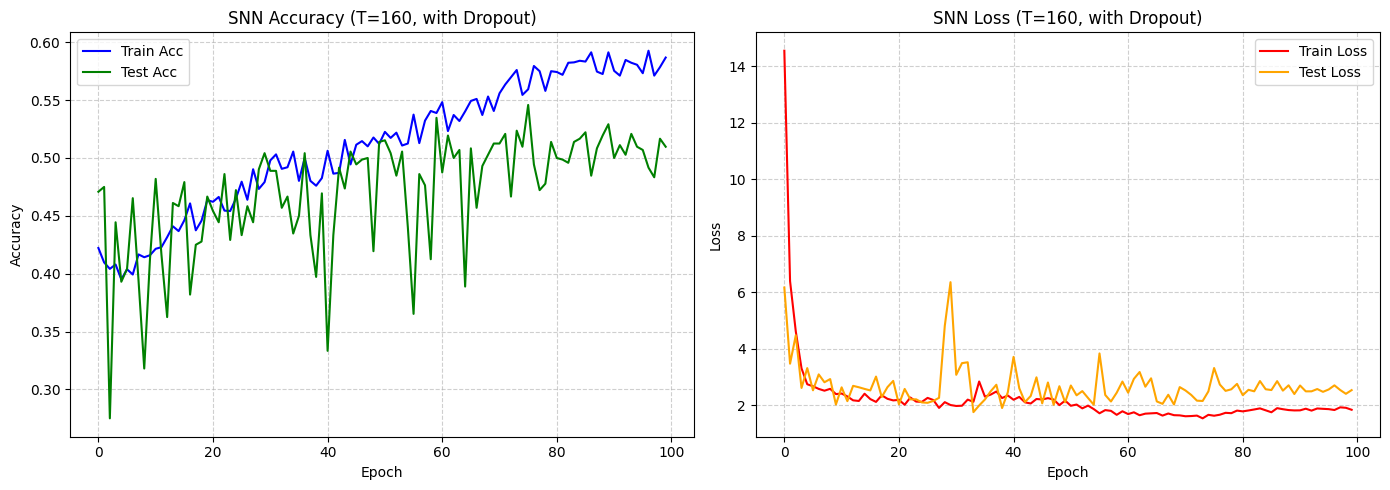

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import snntorch as snn
from snntorch import surrogate
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# MNE 자체 로그 끄기
mne.set_log_level('ERROR')

# --- stdout 음소거 클래스 ---
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# --- 1. 환경 설정 ---
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"🔥 Using device: {device}")

# ==========================================
# 2. Geometric Feature Extractor
# ==========================================
def compute_tangling_torch(x, dx, epsilon=1e-5):
    B, C, T = x.shape
    Q_list = []
    for i in range(B):
        x_diff_sq = (x[i].unsqueeze(-1) - x[i].unsqueeze(-2)).pow(2).sum(dim=0)
        dx_diff_sq = (dx[i].unsqueeze(-1) - dx[i].unsqueeze(-2)).pow(2).sum(dim=0)
        ratio = dx_diff_sq / (x_diff_sq + epsilon)
        mask = torch.eye(T, device=x.device).bool()
        ratio = ratio.masked_fill(mask, 0)
        q_val, _ = ratio.max(dim=-1)
        Q_list.append(q_val)
    return torch.stack(Q_list, dim=0).unsqueeze(1)

def extract_geometric_features_torch(data_tensor):
    n_fft = data_tensor.shape[-1]
    freq = torch.fft.fft(data_tensor, dim=-1)
    h = torch.zeros_like(freq)
    h[..., 0] = freq[..., 0]
    h[..., 1:(n_fft + 1) // 2] = 2 * freq[..., 1:(n_fft + 1) // 2]
    if n_fft % 2 == 0:
        h[..., n_fft // 2] = freq[..., n_fft // 2]
    analytic = torch.fft.ifft(h, dim=-1)
    r = analytic.real

    r_prime = torch.zeros_like(r)
    r_prime[..., 1:-1] = (r[..., 2:] - r[..., :-2]) / 2
    r_prime[..., 0] = r[..., 1] - r[..., 0]
    r_prime[..., -1] = r[..., -1] - r[..., -2]

    r_double_prime = torch.zeros_like(r_prime)
    r_double_prime[..., 1:-1] = (r_prime[..., 2:] - r_prime[..., :-2]) / 2

    num_k = torch.abs(r_prime * r_double_prime)
    den_k = torch.pow(torch.abs(r_prime), 3) + 1e-6
    curvature = num_k / den_k

    r_norm = (r - r.mean(dim=-1, keepdim=True)) / (r.std(dim=-1, keepdim=True) + 1e-6)
    v_norm = (r_prime - r_prime.mean(dim=-1, keepdim=True)) / (r_prime.std(dim=-1, keepdim=True) + 1e-6)

    print(f"\n🌀 Computing Tangling Index for {data_tensor.shape[0]} trials...")
    tangling = compute_tangling_torch(r_norm, v_norm)

    features = torch.cat([r, curvature, tangling], dim=1)
    f_mean = features.mean(dim=(0, 2), keepdim=True)
    f_std = features.std(dim=(0, 2), keepdim=True)
    features = (features - f_mean) / (f_std + 1e-6)
    return features

# ==========================================
# 3. 데이터 로드 (MNE Physionet 1~20)
# ==========================================
def load_physionet_data(subject=1):
    runs = [4, 6, 8, 10, 12, 14]
    raw_fnames = eegbci.load_data(subject, runs, verbose=False)
    raw = concatenate_raws([mne.io.read_raw_edf(f, preload=True, verbose=False) for f in raw_fnames])
    eegbci.standardize(raw)
    montage = mne.channels.make_standard_montage('standard_1005')
    raw.set_montage(montage)

    events, _ = mne.events_from_annotations(raw, verbose=False)
    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

    epochs = mne.Epochs(raw, events, event_id=None, tmin=0., tmax=4.0, proj=True, picks=picks,
                        baseline=None, preload=True, verbose=False)

    labels = epochs.events[:, -1]
    unique_labels = np.unique(labels)
    label_map = {original: idx % 4 for idx, original in enumerate(unique_labels)}
    new_labels = np.array([label_map[l] for l in labels])

    return epochs.get_data(), new_labels

NUM_SUBJECTS = 20
X_list, y_list = [], []

for sub in range(1, NUM_SUBJECTS + 1):
    print(f"\r📊 Loading Data from Physionet... Subject [{sub:02d}/{NUM_SUBJECTS}]", end='', flush=True)
    with HiddenPrints():
        x, y = load_physionet_data(sub)
    X_list.append(x)
    y_list.append(y)
print("\n✅ Data Loading Complete!")

X_tensor_raw = torch.tensor(np.concatenate(X_list, axis=0), dtype=torch.float32).to(device)
y_tensor = torch.tensor(np.concatenate(y_list, axis=0), dtype=torch.long).to(device)

print("🧠 Extracting Geometric Features (Curvature + Tangling)...")
with torch.no_grad():
    X_geo = extract_geometric_features_torch(X_tensor_raw)
print(f"✅ Feature Extraction Complete! Original Shape: {X_geo.shape}")

dataset = TensorDataset(X_geo, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ==========================================
# 4. GeoEEG Spatial-Temporal SNN (V3.0: 최적화 & Dropout)
# ==========================================
class PopulationEncoder(nn.Module):
    def __init__(self, num_neurons, min_val=-3.0, max_val=3.0, sigma=1.0):
        super().__init__()
        self.num_neurons = num_neurons
        mu = torch.linspace(min_val, max_val, num_neurons)
        self.register_buffer('mu', mu)
        self.sigma = sigma

    def forward(self, x):
        B, C, T = x.shape
        x_expanded = x.unsqueeze(-1)
        encoded = torch.exp(-((x_expanded - self.mu)**2) / (2 * self.sigma**2))
        return encoded.permute(0, 1, 3, 2).reshape(B, C * self.num_neurons, T)

class GeoEEGSNN(nn.Module):
    def __init__(self, num_channels=129, num_classes=4, pop_neurons=4, beta=0.90):
        super().__init__()
        self.encoder = PopulationEncoder(num_neurons=pop_neurons, min_val=-3, max_val=3, sigma=1.5)
        encoded_channels = num_channels * pop_neurons

        self.conv_spatial = nn.Conv1d(encoded_channels, 128, kernel_size=1, bias=False)
        self.bn_spatial = nn.BatchNorm1d(128)

        self.conv_temporal = nn.Conv1d(128, 128, kernel_size=5, padding=2, bias=False)
        self.bn_temporal = nn.BatchNorm1d(128)

        # [핵심 추가 1] 시간축 압축 (T=641 -> 160)
        self.pool_time = nn.AvgPool1d(kernel_size=4, stride=4)

        # [핵심 추가 2] 오버피팅 억제용 Dropout
        self.dropout1d = nn.Dropout1d(p=0.3)
        self.dropout = nn.Dropout(p=0.3)

        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.fc1 = nn.Linear(128, 64)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid())
        self.fc_out = nn.Linear(64, num_classes)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(), output=True)

    def forward(self, x):
        c = self.encoder(x)
        c = torch.relu(self.bn_spatial(self.conv_spatial(c)))
        c = torch.relu(self.bn_temporal(self.conv_temporal(c)))

        c = self.pool_time(c) # 압축: (Batch, 128, 160)
        c = self.dropout1d(c) # Dropout

        c_seq = c.permute(2, 0, 1) # SNN 루프 진입: (T=160, Batch, 128)

        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem_out = self.lif_out.init_leaky()

        mem_rec = []
        for step in range(c_seq.size(0)): # 160번만 순회! 엄청난 속도 향상.
            spk1, mem1 = self.lif1(c_seq[step], mem1)

            fc1_out = self.dropout(self.fc1(spk1)) # Dropout
            spk2, mem2 = self.lif2(fc1_out, mem2)

            spk_out, mem_out = self.lif_out(self.fc_out(spk2), mem_out)
            mem_rec.append(mem_out)

        return torch.stack(mem_rec, dim=0)

# ==========================================
# 5. 학습 루프 (Train & Validation)
# ==========================================
model = GeoEEGSNN(num_channels=X_geo.shape[1], num_classes=4, pop_neurons=4).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.01)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train_acc_hist, test_acc_hist = [], []
train_loss_hist, test_loss_hist = [], []

print(f"⚡ Start Training GeoEEG-SNN (100 Epochs, T=160, Dropout applied)...")
for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    correct, total, iter_loss = 0, 0, 0
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()

        mem_rec = model(data)
        out_voltage = mem_rec.sum(dim=0)
        loss = criterion(out_voltage, targets)
        loss.backward()
        optimizer.step()

        iter_loss += loss.item()
        _, predicted = out_voltage.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    train_acc = correct / total
    train_loss = iter_loss / len(train_loader)
    scheduler.step()

    # --- Validation (Test) ---
    model.eval()
    t_correct, t_total, t_loss = 0, 0, 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            mem_rec = model(data)
            out_voltage = mem_rec.sum(dim=0)
            loss = criterion(out_voltage, targets)

            t_loss += loss.item()
            _, predicted = out_voltage.max(1)
            t_total += targets.size(0)
            t_correct += (predicted == targets).sum().item()

    test_acc = t_correct / t_total
    test_loss = t_loss / len(test_loader)

    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)
    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:03d}/{num_epochs}] | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc*100:.1f}% | "
              f"Test Loss: {test_loss:.4f} Acc: {test_acc*100:.1f}%")

print("🎉 학습 완료! 이제 그래프로 70%를 돌파했는지 확인해보자.")

# 결과 시각화
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label='Train Acc', color='blue')
plt.plot(test_acc_hist, label='Test Acc', color='green')
plt.title("SNN Accuracy (T=160, with Dropout)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label='Train Loss', color='red')
plt.plot(test_loss_hist, label='Test Loss', color='orange')
plt.title("SNN Loss (T=160, with Dropout)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()